In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from scipy.special import gamma
import numpy as np
import emcee
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
import glob
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import matplotlib.cm as cm
import matplotlib.mlab as mlab

In [3]:
path = "/data/OWN/paramstest/e01_t20/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,stars,gas")

loading Dark matter..
loading Stars..
loading Gas..


In [4]:
myhalo.r_virial(600)

| r_200 = 231.4453125
---- taking particles inside 2.5 * r200
| number of praticles inside 2.5 * r200 
| dm mass       =  1.442e+12 M_sun
| p_dm_200      =  9.289e+05 particles
| stellar mass  =  1.318e+11 M_sun
| p_st_200      =  4.688e+06 psrticles
| gas mass      =  1.412e+11 M_sun
| p_gs_200      =  2.091e+06 particles
---- rotating galaxy 
| Diagonal matrix computed 
|    |22, 0, 0|
| D =| 0,19, 0|
|    | 0, 0, 1|


In [5]:
ok,myhalo.st.rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),
                                           dtype=np.float32), myhalo.st.mass)

In [6]:
def edge_on_st(sim,lims,points):
    #disk = sim.st.pos3d[:,2]
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[:,0], 
                                       sim.st.pos3d[:,2],
                                       bins=(edges, edges),
                                       weights=sim.st.mass)
    result = H.T
    return result, edges

def edge_on_age(sim,lims,points,age_min=-14,age_max=0.2):
    disk = (sim.st.age[:]>age_min)&(sim.st.age[:]<age_max)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[disk,0], 
                                       sim.st.pos3d[disk,2],
                                       bins=(edges, edges),
                                       weights=sim.st.mass[disk])
    result = H.T
    return result, edges


def face_on_st(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[:,0], 
                                       sim.st.pos3d[:,1],
                                       bins=(edges, edges),
                                       weights=sim.st.mass)
    result = H.T
    return result, edges

def face_on_st_age(sim,lims,points,age_min=-14,age_max=0.2):
    disk = (sim.st.age[:]>age_min)&(sim.st.age[:]<age_max)
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.st.pos3d[disk,0], 
                                       sim.st.pos3d[disk,1],
                                       bins=(edges, edges),
                                       weights=sim.st.mass[disk])
    result = H.T
    return result, edges

In [ ]:
length=15.
hist2D, edges = edge_on_st(myhalo,[-length,length],250)
fig, ax = plt.subplots()
mass_1 = ax.imshow(hist2D, interpolation='nearest', origin='low',cmap="bone",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')




<IPython.core.display.Javascript object>


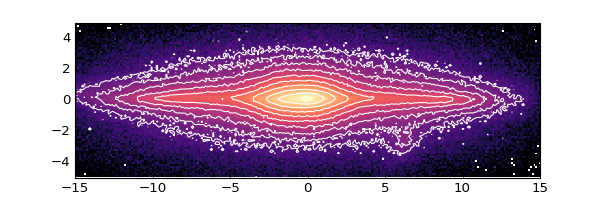

(-5, 5)

In [10]:
fig, ax = plt.subplots(figsize=[7.5,2.5])
X, Y = np.meshgrid(edges[1:], edges[1:])
Z = hist2D
mass_1 = ax.imshow(Z, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )


CS = ax.contour(X, Y, Z,np.logspace(6,8.5,10),colors='w')
ax.set_ylim([-5,5])


<IPython.core.display.Javascript object>


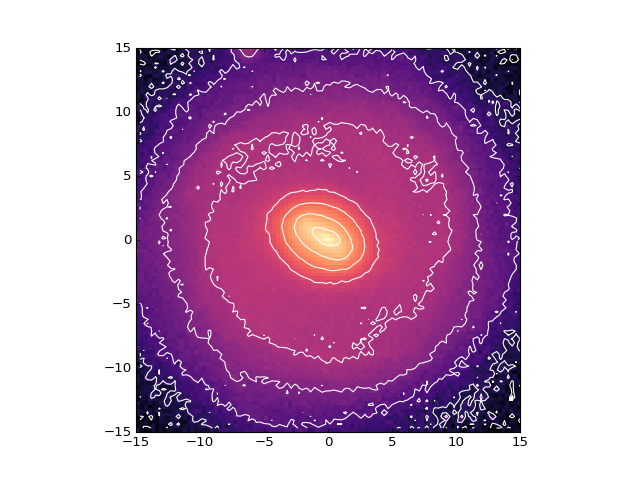

In [11]:
face_on, edges = face_on_st(myhalo,[-length,length],100)#H.T
fig, ax = plt.subplots()
X, Y = np.meshgrid(edges[1:], edges[1:])
Z = face_on


mass_1 = ax.imshow(face_on, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )
CS = ax.contour(X, Y, Z,np.logspace(2,10.5,20),colors='w')


In [12]:
myhalo.st.age.max()

0.0018101855

<IPython.core.display.Javascript object>


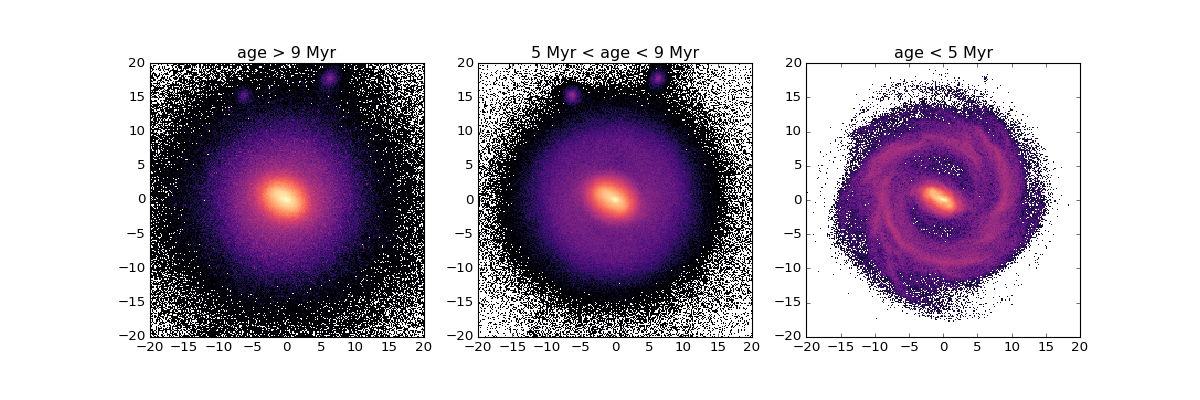

In [13]:
length = 20
fig, ax = plt.subplots(1,3,figsize=[15,5])
#titles
ax[0].set_title("age > 9 Myr")
ax[1].set_title("5 Myr < age < 9 Myr")
ax[2].set_title("age < 5 Myr")
# generate histogram
young_st_face, edges = face_on_st_age(myhalo,[-length,length],250,age_max=-9)#H.T
mass_1 = ax[0].imshow(young_st_face, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )
# generate histogram
old_st_face, edges = face_on_st_age(myhalo,[-length,length],250,age_min=-9,age_max=-5)#H.T

mass_1 = ax[1].imshow(old_st_face, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                      )
old_st_face, edges = face_on_st_age(myhalo,[-length,length],250,age_min=-1.8)#H.T

mass_1 = ax[2].imshow(old_st_face, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e4)
                      )

<IPython.core.display.Javascript object>


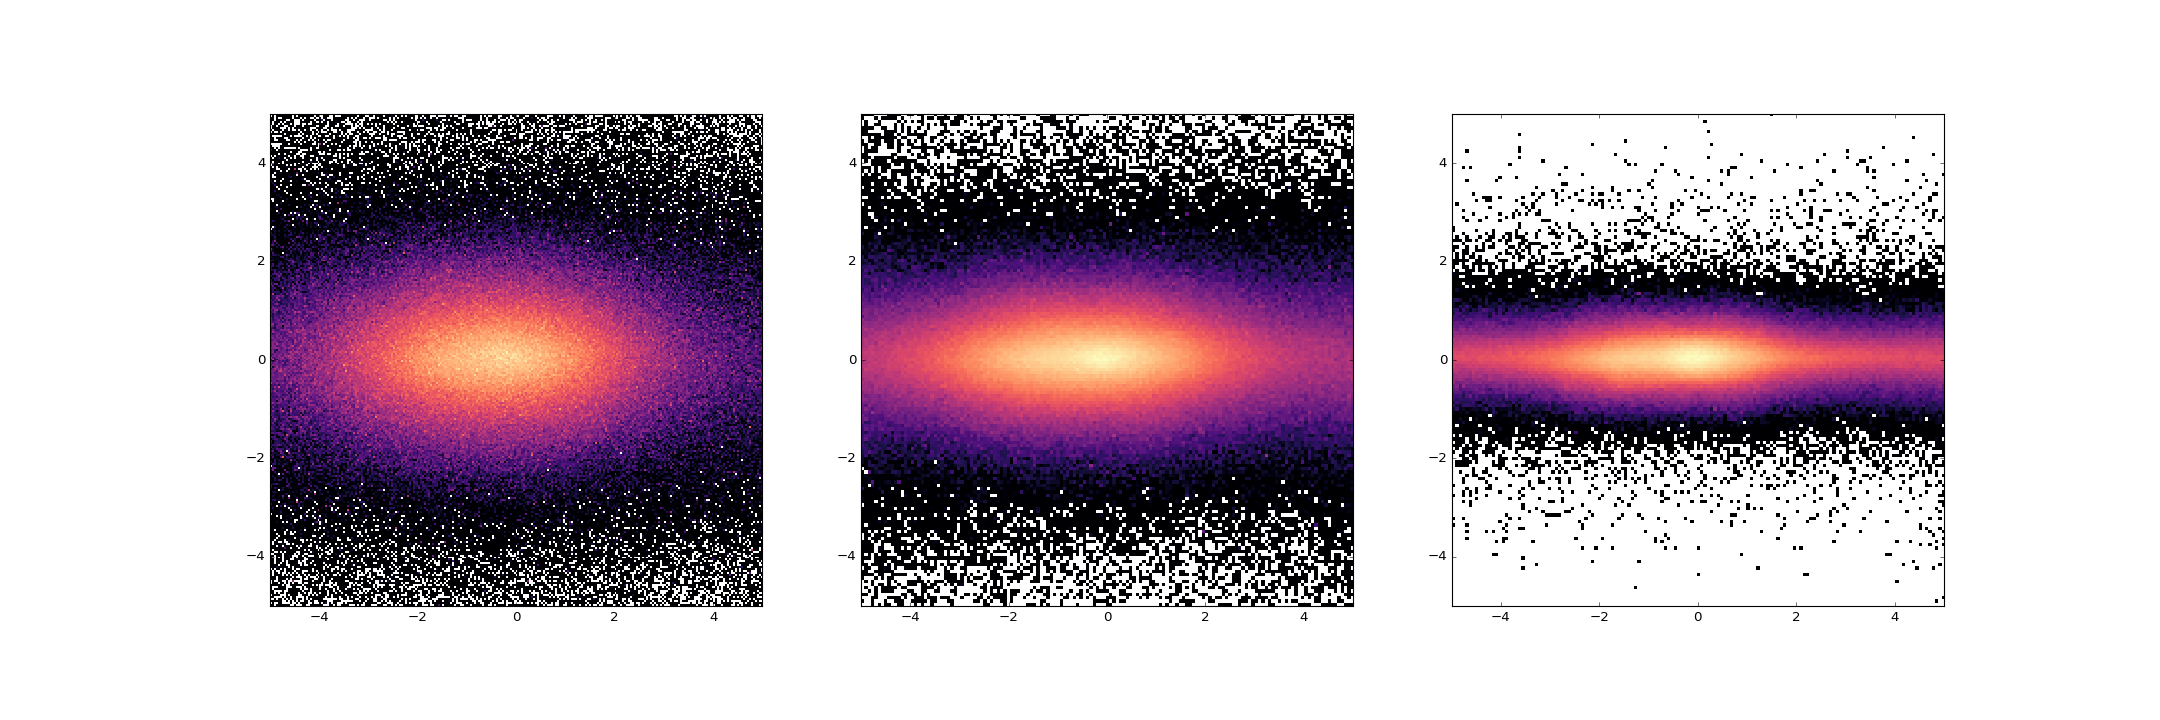

In [14]:
fig, ax = plt.subplots(1,3,figsize=[27,9])
X, Y = np.meshgrid(edges[1:], edges[1:])
Z = face_on
length=5
edge_on, edges = edge_on_age(myhalo,[-length,length],250,age_max=-9)#H.T

mass_1 = ax[0].imshow(edge_on, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )
#CS = ax.contour(X, Y, Z,np.logspace(2,10.5,20),colors='w')
edge_on, edges = edge_on_age(myhalo,[-length,length],150,age_min=-9,age_max=-5)#H.T

mass_1 = ax[1].imshow(edge_on, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                      )

edge_on, edges = edge_on_age(myhalo,[-length,length],150,age_min=-5)#H.T

mass_1 = ax[2].imshow(edge_on, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                      )

<IPython.core.display.Javascript object>


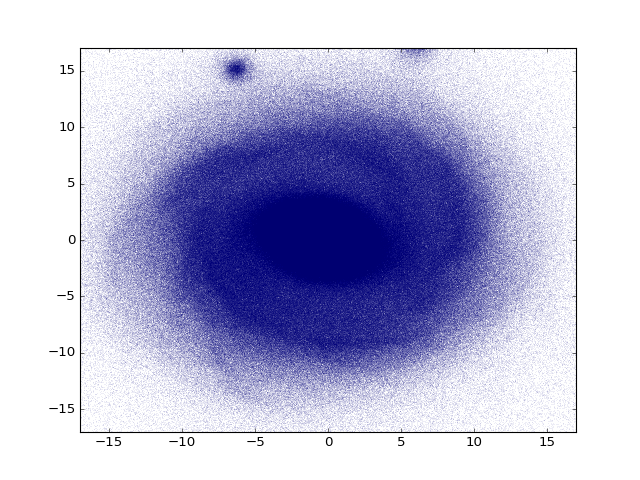

In [21]:
fig, ax = plt.subplots()
ax.set_ylim([-17,17])
ax.set_xlim([-17,17])
ax.scatter(myhalo.st.pos3d[:,0],myhalo.st.pos3d[:,1],s=0.07,linewidths=0, alpha=0.5 )

In [ ]:
face_on, edges = face_on_st_age(myhalo,[-length,length],200,age_min=-2)#H.T
fig, ax = plt.subplots()
X, Y = np.meshgrid(edges[1:], edges[1:])
Z = face_on


mass_1 = ax.imshow(face_on, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )
CS = ax.contour(X, Y, Z,np.logspace(5.4,10.5,11),colors='w')

In [15]:
stars_bins=70

print 10**1.3
xedges = np.logspace(-1,np.log10(10),stars_bins)
yedges = np.linspace(-2.,2.,stars_bins/2)
dens_hist = np.zeros([len(yedges)-1,len(xedges)-1])
sigma_st = np.zeros([len(yedges)-1,len(xedges)-1])

print dens_hist.shape
for i in range(len(xedges[:-1])):
    for j in range(len(yedges[:-1])):
        Rcon = (myhalo.st.R >= xedges[i] )&(myhalo.st.R < xedges[i+1] )
        Zcon = (myhalo.st.pos3d[:,2] >= yedges[j])&(myhalo.st.pos3d[:,2] < yedges[j+1])
        mass = np.sum(myhalo.st.mass[np.where(Rcon&Zcon)])
        sigma_st[j][i] = np.std(myhalo.st.rho[np.where(Rcon&Zcon)])
        volume = np.pi * (yedges[j+1]-yedges[j]) * (xedges[i+1]**2 - xedges[i]**2)
        dens_hist [j][i] = mass / volume 
    


19.9526231497
(34, 69)


KeyboardInterrupt: 

In [16]:
fig ,ax = plt.subplots(figsize=[18,2])

ax.set_xscale('log')
real = ax.imshow(dens_hist, interpolation='nearest', origin='low',
                  extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])#,
                   norm=LogNorm(vmin=1e7))
divider = make_axes_locatable(ax)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(real,cax=cax)#,orientation='horizontal')


IndentationError: unexpected indent (<ipython-input-16-14d4d285eeab>, line 6)

In [ ]:
def stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    def McMBulge(U,B_0,r0,al,r_cut):
        x = np.sqrt(U[0]**2 + (U[1]/q)**2)
        bulge = (10**B_0) * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

    def McMDisc(x,z,z_d,D_0,Rd):
        disc = (10**D_0) * np.exp(- (abs(z) / z_d) - (x / Rd))
        return disc
    U = [R,z]
    return (McMBulge(U,B_0,r0,al,r_cut)+McMDisc(U[0],U[1],z_d,d_0,Rd)+McMDisc(U[0],U[1],z_D,D_0,RD))



R_array = (xedges[1:] + xedges[:-1])/2
Z_array = (yedges[1:] + yedges[:-1])/2

R , Z = np.meshgrid(R_array,Z_array)

def chi2_st(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    chi2_array =np.array([])
    expected = stars(R,Z,B_0,r0,al,r_cut,q,D_0,z_d,Rd,D_0,z_D,RD)
    observed = dens_hist
    #c = ((observed) - (expected))**2 / sigma_st
    c = (np.log10(observed) - np.log10(expected))**2 / np.log10(expected)**2

    chi2_array = np.append(chi2_array,c)
    c_val = np.nansum(chi2_array)
    return (c_val)# + diff**2)


def mass_check(B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    bins = 101
    edge = 20
    zedge = edge/10.
    xe, ye = np.linspace(0,edge,bins ),np.linspace(-zedge,zedge,bins)
    R_test,Z_test = (xe[1:] + xe[:-1])/2 , (ye[1:] + ye[:-1])/2
    U = np.meshgrid(R_test,Z_test)
    rho = 2. * np.pi * R_test * stars(U[0],U[1],B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD)
    I = np.zeros( len(rho) )
    for i in range(len(rho)):
        I[i] = np.trapz( rho[i], R_test )
    F = np.trapz( I, Z_test )
    data_in = np.sum(myhalo.st.mass[np.where((myhalo.st.R<50.)&(np.abs(myhalo.st.pos3d[:,2])<zedge))])
    diff = (data_in - F)**2
    return  diff

In [ ]:
m1=Minuit(chi2_st, 
         B_0=10.58, error_B_0=0.5,     limit_B_0=(10,10.8),
         r0=0.5,    error_r0=0.1,     limit_r0=(0.01,3.6),
         al=0.01,     error_al=0.1,    limit_al=(0,5.),
         r_cut=0.55,  error_r_cut=0.1,   limit_r_cut=(0.1,0.6),
         q=0.62,      error_q=0.1,     limit_q=(0,1.),
         d_0=9.6,    error_d_0=1,     limit_d_0=(9.,10.5),
         z_d=0.2,  error_z_d=0.2,  limit_z_d=(0.,0.5),
         Rd=0.5,     error_Rd=0.01,        limit_Rd=(0.1,1.0),
         D_0=9.4,    error_D_0=1,     limit_D_0=(9.,10.5),
         z_D=0.6,  error_z_D=0.02,  limit_z_D=(0.3,1.2),
         RD=2.3,     error_RD=0.01,        limit_RD=(1.2,4.))
#         print_level=0)
m1.migrad();

err = 0.1
upp = 1.1
low = 0.95
m2=Minuit(mass_check, 
         B_0=m1.values['B_0'], error_B_0=m1.values['B_0']*err, limit_B_0=(m1.values['B_0']*low,m1.values['B_0']*upp),
         r0=m1.values['r0'], error_r0=m1.values['r0']*err, limit_r0=(m1.values['r0']*low,m1.values['r0']*upp),
         al=m1.values['al'], error_al=m1.values['al']*err, limit_al=(m1.values['al']*low,m1.values['al']*upp),
         r_cut=m1.values['r_cut'],  error_r_cut=m1.values['r_cut']*err, limit_r_cut=(m1.values['r_cut']*low,m1.values['r_cut']*upp),
         q=m1.values['q'], error_q=m1.values['q']*err, limit_q=(m1.values['q']*low,m1.values['q']*upp),
         d_0=m1.values['d_0'], error_d_0=m1.values['d_0']*err, limit_d_0=(m1.values['d_0']*low,m1.values['d_0']*upp),
         z_d=m1.values['z_d'], error_z_d=m1.values['z_d']*err,  limit_z_d=(m1.values['z_d']*low,m1.values['z_d']*upp),
         Rd=m1.values['Rd'], error_Rd=m1.values['Rd']*err, limit_Rd=(m1.values['Rd']*low,m1.values['Rd']*upp),
         D_0=m1.values['D_0'], error_D_0=m1.values['D_0']*err, limit_D_0=(m1.values['D_0']*low,m1.values['D_0']*upp),
         z_D=m1.values['z_D'], error_z_D=m1.values['z_D']*err,  limit_z_D=(m1.values['z_D']*low,m1.values['z_D']*upp),
         RD=m1.values['RD'], error_RD=m1.values['RD']*err, limit_RD=(m1.values['RD']*low,m1.values['RD']*upp))
#         print_level=0)

m2.migrad();